# Testszenario 2: Polling

### Daten einlesen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.stats.mstats import winsorize

#read Worker Power CSV
worker_power = pd.read_csv("CSV-polling/2024-02-13 15-12-00 Worker Power.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe Power CSV
zeebe_power = pd.read_csv("CSV-polling/2024-02-13 15-12-00 Zeebe Power.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe gRPC CSV
zeebe_grpc = pd.read_csv("CSV-polling/2024-02-13 15-12-00 Zeebe gRPC.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels


### Log-Daten einlesen

In [2]:
LOG_PATH = "shell-scripts/logs/polling/"
LOG_FILE="polling.sh-2024-02-13-15-12-00"


def read_start_times(LOG_PATH = LOG_PATH,LOG_NAME = LOG_FILE):
    log_line = []
    start_times = []
    settings_list = []

    with open(LOG_PATH+LOG_NAME, "r") as file:
        log_line = file.readlines()

    # remove newline-character, 
    for i, time in enumerate(log_line):
        log_line = time[:-1].split()

        start_times.append(f"{log_line[0]} {log_line[1]}")
        settings_list.append(f"pI={log_line[2]} rto={log_line[3]}")

    return start_times, settings_list


start_times, settings_list = read_start_times()

### Gesamtzeitreihe erstellen

<Axes: xlabel='Time'>

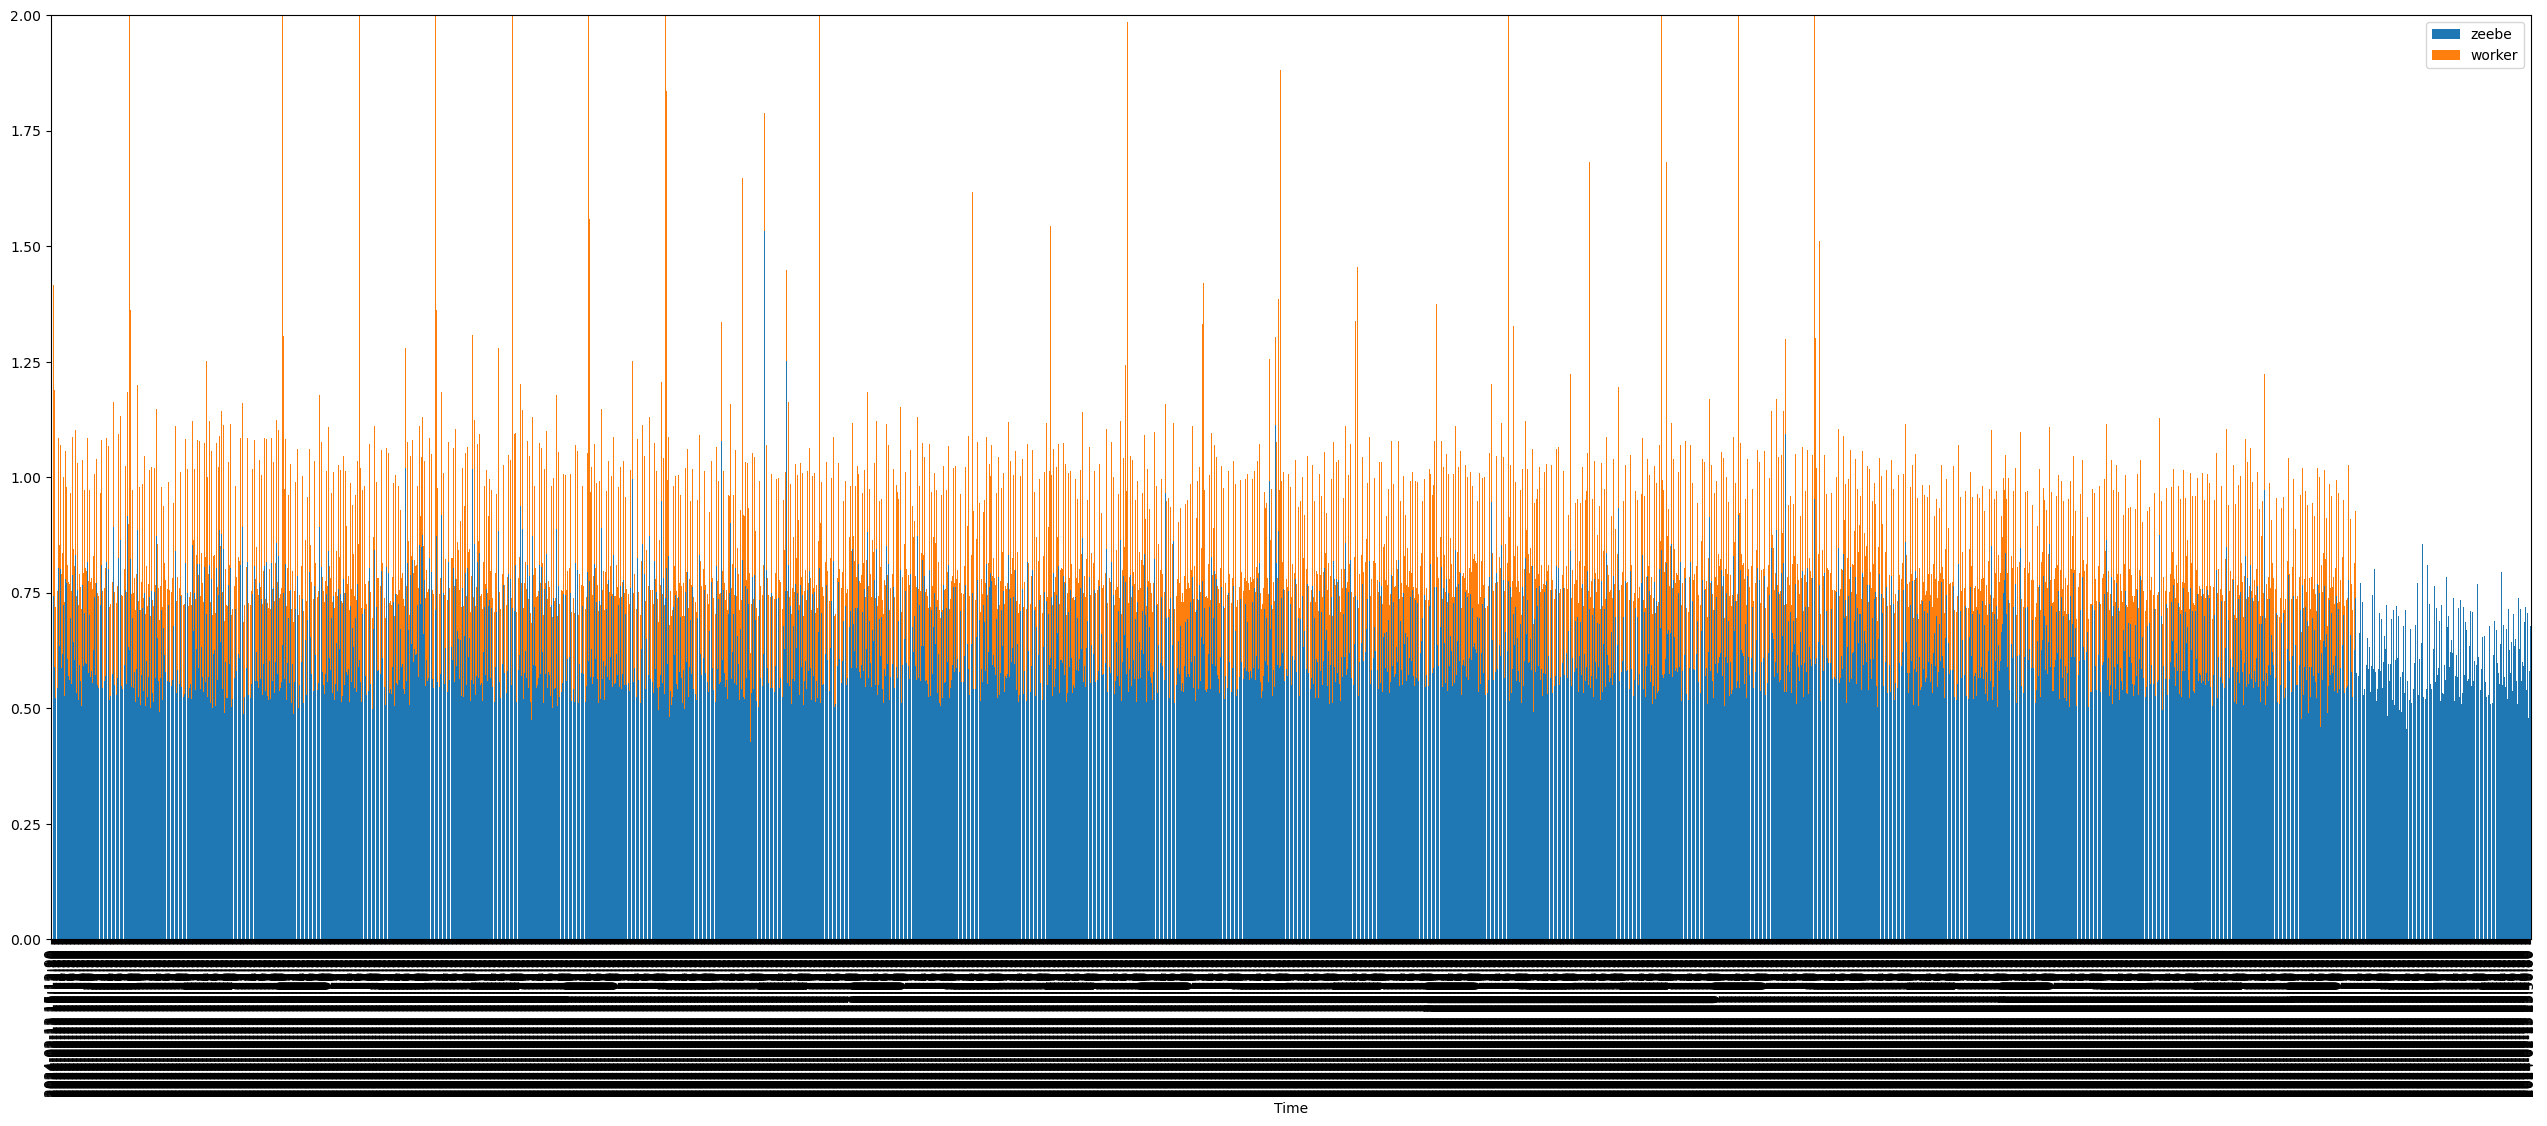

In [3]:
data_raw = pd.DataFrame()

worker_cols = [col for col in worker_power.columns if 'restworkerjava' in col ]
camunda_cols = [col for col in zeebe_power.columns if 'zeebe' in col ]

# sum up PKG + DRAM + OTHER for each time stamp
data_raw['zeebe'] = zeebe_power[camunda_cols].sum(axis=1)
data_raw['worker'] = worker_power[worker_cols].sum(axis=1)

# add grpc
data_raw['grpc'] = zeebe_grpc['ActivateJobs (OK)']

data_raw[['zeebe','worker']].plot(kind='bar', stacked=True, figsize=[32,12], ylim= [0,2], width=0.9)

### Leerlauf subtrahieren

In [4]:
IDLE_START = "2024-02-13 23:13:00"

idle_raw = data_raw.loc[IDLE_START:,'zeebe']

num_elements_to_remove = len(idle_raw.index) % 3

idle_raw = idle_raw[:-num_elements_to_remove]

# generate medians for 00:00, 00:10, 00:20

# reshape series
idle_pattern = pd.DataFrame(idle_raw.to_numpy().reshape(-1, 3), columns=['00:00', '00:10', '00:20'])

medians = idle_pattern.median(axis=0)

medians

00:00    0.71495
00:10    0.54920
00:20    0.58430
dtype: float64

In [5]:
def remove_idle_power(df, pattern, column):
    pattern_series = pd.Series()
    
    difference = 0
    
    # repeat the pattern until length of df.index is reached
    while len(pattern_series) < len(df.index):
        pattern_series = pd.concat([pattern_series, pattern])
        difference = len(pattern_series) - len(df.index)
    
    print(difference)

    pattern_series = pattern_series[:-difference]
    pattern_series.index = df.index

    pattern_series = pattern_series.apply(pd.to_numeric, errors='coerce')

    df[f"{column}_no_idle"] = df[column] - pattern_series
    df[f"{column}_idle"] = pattern_series


    return df

data_raw = remove_idle_power(data_raw, medians, 'zeebe')
# cap_no_idle = completion_and_power

2


### Messzyklen separieren & Ausreißer entfernen

In [6]:
def filter_outliers_iqr_per_column(column, multiplier=1.5):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = ((column < lower_bound) | (column > upper_bound))
    return column[~outliers]

# Function to apply the IQR method for each row in a DataFrame
def filter_outliers_iqr(df, multiplier=1.5):
    return df.apply(filter_outliers_iqr_per_column, axis=0).apply(pd.to_numeric, errors='coerce')

In [7]:
LENGTH_OF_CYCLE = 3
LENGTH_OF_MEASUREMENT = 6 * 15 # Measurements per second * length of measurements in minutes
LENGTH_OF_START_PHASE = 6
DURATION_OF_MEASUREMENT_INTERVAL = 10 # seconds

worker_cycles = pd.DataFrame()
zeebe_cycles = pd.DataFrame()
grpc_cycles = pd.DataFrame()

worker_measurements = pd.DataFrame()
zeebe_measurements = pd.DataFrame()
grpc_measurements = pd.DataFrame()

for i, t in enumerate(start_times):
    start_index = data_raw.index.get_loc(t)

    start_of_measurement = start_index + LENGTH_OF_START_PHASE
    end_of_measurement = start_index + LENGTH_OF_START_PHASE + LENGTH_OF_MEASUREMENT

    # WORKER
    ########

    worker_measurement = data_raw.iloc[start_of_measurement : end_of_measurement,:].loc[:,'worker'].reset_index(drop=True)
    worker_cycle = pd.DataFrame(worker_measurement.to_numpy().reshape(-1, 3), columns=['00:00', '00:10', '00:20'])

    # remove outliers
    worker_cycle = filter_outliers_iqr(worker_cycle)

    # add to main worker df
    worker_cycles = pd.concat([worker_cycles, worker_cycle.mean()], axis=1)
    
    # ZEEBE
    #######

    zeebe_measurement = data_raw.iloc[start_of_measurement : end_of_measurement,:].loc[:,'zeebe'].reset_index(drop=True)
    zeebe_cycle = pd.DataFrame(zeebe_measurement.to_numpy().reshape(-1, 3), columns=['00:00', '00:10', '00:20'])

    # remove outliers
    zeebe_cycle = filter_outliers_iqr(zeebe_cycle)

    # add to main worker df
    zeebe_cycles = pd.concat([zeebe_cycles, zeebe_cycle.mean()], axis=1)


    # gRPC
    ######

    grpc_measurement = data_raw.iloc[start_of_measurement : end_of_measurement,:].loc[:,'grpc'].reset_index(drop=True)
    grpc_cycle = pd.DataFrame(grpc_measurement.to_numpy().reshape(-1, 3), columns=['00:00', '00:10', '00:20'])

    # add to main worker df
    grpc_cycles = pd.concat([grpc_cycles, grpc_cycle.mean(skipna=False)], axis=1)

    # WHOLE CONFIGURATION MEASUREMENTS
    ##################################

    worker_measurements = pd.concat([worker_measurements, worker_measurement.reset_index(drop=True)], axis=1) 
    zeebe_measurements = pd.concat([zeebe_measurements, worker_measurement.reset_index(drop=True)], axis=1) 
    grpc_measurements = pd.concat([grpc_measurements, worker_measurement.reset_index(drop=True)], axis=1) 

    
worker_cycles.columns = settings_list
zeebe_cycles.columns = settings_list
grpc_cycles.columns = settings_list

In [8]:
cycle_means = pd.concat([worker_cycles.median(axis=0), zeebe_cycles.median(axis=0),  grpc_cycles.sum(axis=0) *10 ], axis=1)
cycle_means.columns = ['worker', 'zeebe', 'grpc']
cycle_means['grpc'] = cycle_means['grpc'] * 2

#### Style Options

In [9]:
# define Colors

lightgreen = "#6ccbb2"
green = "#437e6e"
darkblue = "#90c5e2"
blue = "#a2d8ff"
black = "#1f1f1f"
grey = "#f3f3f2"
white = "#ffffff"
extra1 = "#8c713f"
extra2 = "#d9ab73"

colors = [
    lightgreen,
    green,
    darkblue,
    extra1,
    black,
    extra2,
    grey,
    blue,
    white,
]

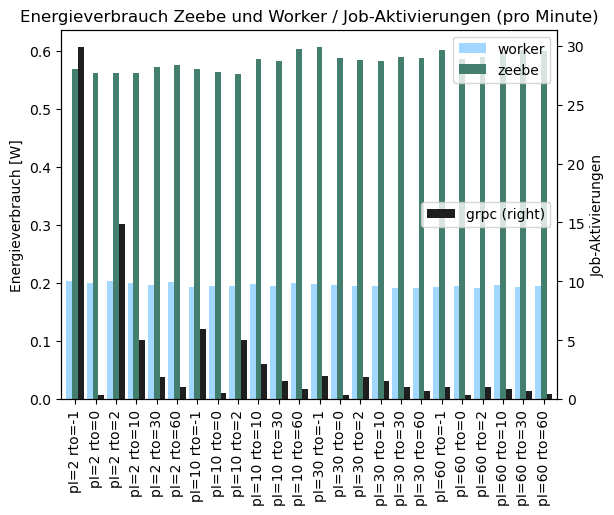

In [10]:
ax = cycle_means.plot(
    kind='bar', 
    secondary_y='grpc',
    width= 0.85,
    color= [blue, green, black],
    title='Energieverbrauch Zeebe und Worker / Job-Aktivierungen (pro Minute)'
    )

ax.legend(loc='upper right')
ax.set_ylabel('Energieverbrauch [W]')
ax.right_ax.set_ylabel('Job-Aktivierungen')
ax.right_ax.legend(loc='center right')


<Axes: >

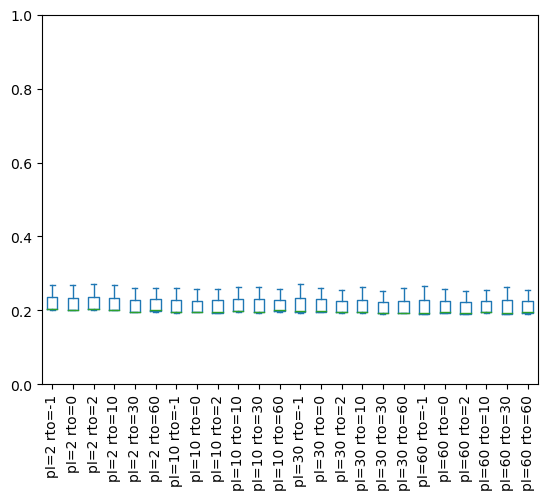

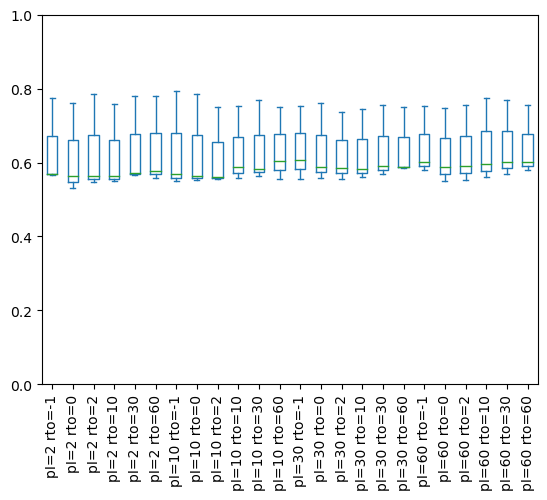

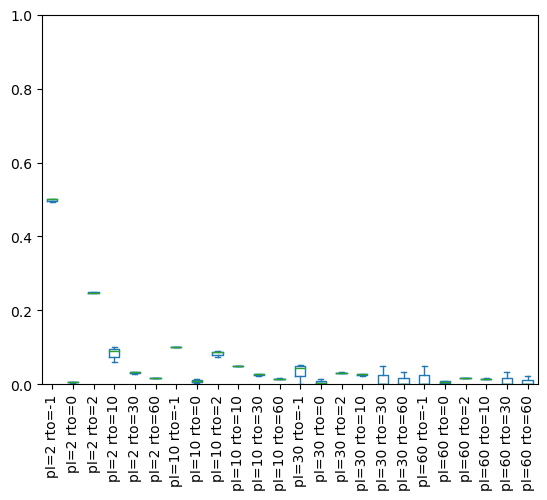

In [11]:
ylim= [0,1]

worker_cycles.plot(kind='box', rot= 90, ylim = ylim)
zeebe_cycles.plot(kind='box', rot= 90, ylim = ylim)
grpc_cycles.plot(kind='box', rot= 90, ylim = ylim)

In [12]:
# Format options

pd.options.display.float_format = '{:.1f}%'.format

In [13]:
# create 6x4 Table

worker_overview_arr = cycle_means['worker'].to_numpy().reshape(4,6)
worker_overview = pd.DataFrame(worker_overview_arr, index = ['pI=2', 'pI=10', 'pI=30', 'pI=60' ], columns = ['rto=-1', 'rto=0', 'rto=2', 'rto=10', 'rto=30', 'rto=60' ])

worker_median = cycle_means['worker'].median()
worker_ratio = pd.DataFrame(worker_overview_arr, index = ['pI=2', 'pI=10', 'pI=30', 'pI=60' ], columns = ['rto=-1', 'rto=0', 'rto=2', 'rto=10', 'rto=30', 'rto=60' ])
worker_ratio = (worker_ratio / worker_median * 100) - 100

print(worker_median)
worker_ratio



0.19610296296296295


,rto=-1,rto=0,rto=2,rto=10,rto=30,rto=60
pI=2,4.1%,2.5%,4.0%,2.4%,0.0%,3.0%
pI=10,-0.9%,-0.4%,-0.4%,1.1%,-0.1%,2.0%
pI=30,1.3%,0.8%,-0.2%,-0.0%,-1.8%,-2.0%
pI=60,-1.7%,-0.7%,-2.1%,0.3%,-1.4%,0.0%


In [14]:
# create 6x4 Table

zeebe_overview_arr = cycle_means['zeebe'].to_numpy().reshape(4,6)
zeebe_overview = pd.DataFrame(zeebe_overview_arr, index = ['pI=2', 'pI=10', 'pI=30', 'pI=60' ], columns = ['rto=-1', 'rto=0', 'rto=2', 'rto=10', 'rto=30', 'rto=60' ])

zeebe_median = cycle_means['zeebe'].median()
zeebe_ratio = pd.DataFrame(zeebe_overview_arr, index = ['pI=2', 'pI=10', 'pI=30', 'pI=60' ], columns = ['rto=-1', 'rto=0', 'rto=2', 'rto=10', 'rto=30', 'rto=60' ])
zeebe_ratio = (zeebe_ratio / zeebe_median * 100) - 100

print(zeebe_ratio.min().min())
print(zeebe_ratio.max().max())

zeebe_ratio

-4.2544841191625125
3.58988995309619


,rto=-1,rto=0,rto=2,rto=10,rto=30,rto=60
pI=2,-2.9%,-4.0%,-4.0%,-4.0%,-2.2%,-1.6%
pI=10,-2.9%,-3.7%,-4.3%,0.1%,-0.4%,3.1%
pI=30,3.6%,0.4%,-0.1%,-0.4%,0.7%,0.5%
pI=60,2.8%,0.2%,0.7%,1.8%,2.7%,2.5%


In [15]:
pd.options.display.float_format = '{:.4f}'.format
cycle_means

,worker,zeebe,grpc
pI=2 rto=-1,0.2041,0.5689,29.8667
pI=2 rto=0,0.2010,0.5622,0.3333
pI=2 rto=2,0.2039,0.5625,14.8667
pI=2 rto=10,0.2008,0.5626,5.0000
pI=2 rto=30,0.1962,0.5728,1.8667
pI=2 rto=60,0.2021,0.5764,1.0000
pI=10 rto=-1,0.1944,0.5686,6.0000
pI=10 rto=0,0.1954,0.5639,0.5333
pI=10 rto=2,0.1952,0.5608,5.0000
pI=10 rto=10,0.1983,0.5866,3.0000


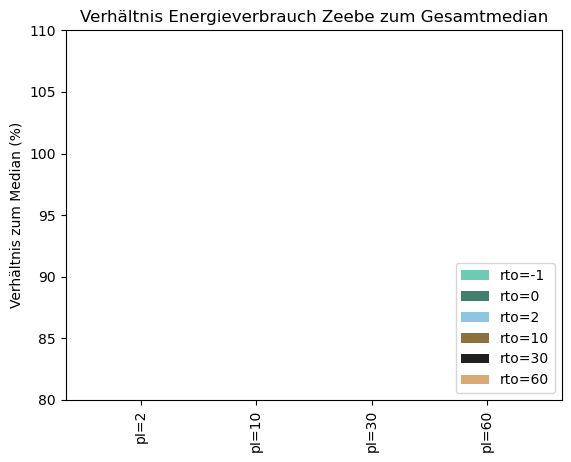

In [16]:
ax = zeebe_ratio.plot(
    kind='bar', 
    width = 0.8, 
    title="Verhältnis Energieverbrauch Zeebe zum Gesamtmedian",
    ylabel= "Verhältnis zum Median (%)",
    ylim= [80,110],
    color = colors
    )

ax.legend(loc='lower right')

In [30]:
# Params
index_6x4 = ['pI=2', 'pI=10', 'pI=30', 'pI=60' ] 
columns_6x4 = ['rto=-1', 'rto=0', 'rto=2', 'rto=10', 'rto=30', 'rto=60' ]

In [17]:
# create 6x4 Table

pd.options.display.float_format = '{:.1f}'.format

grpc_overview_arr = cycle_means['grpc'].to_numpy().reshape(4,6)
grpc_overview = pd.DataFrame(grpc_overview_arr, index = index_6x4, columns = columns_6x4)


grpc_sum = pd.DataFrame(grpc_overview_arr, index = index_6x4, columns = columns_6x4)
grpc_sum = grpc_sum

grpc_sum

,rto=-1,rto=0,rto=2,rto=10,rto=30,rto=60
pI=2,29.9,0.3,14.9,5.0,1.9,1.0
pI=10,6.0,0.5,5.0,3.0,1.5,0.9
pI=30,1.9,0.4,1.9,1.5,1.0,0.7
pI=60,1.0,0.3,1.0,0.9,0.7,0.5


In [28]:
worker_measurements.columns = settings_list
zeebe_measurements.columns = settings_list

#### Für Anhang:

In [32]:
# worker_measurements fluktuation checken

worker_deviations_from_median = pd.DataFrame()
worker_median_deviation_from_median = pd.Series()
pd.options.display.float_format = '{:.2}%'.format


for c in worker_measurements.columns:
    temp = worker_measurements[c].to_numpy().reshape(30,3)
    temp_series = filter_outliers_iqr(pd.DataFrame(temp)).mean(axis=1)

    temp_median = temp_series.median()

    worker_deviations_from_median[c] = temp_series 
    worker_median_deviation_from_median[c] = worker_deviations_from_median[c].std() / temp_median * 100




# Im Anhang:
worker_std = pd.DataFrame(worker_median_deviation_from_median.to_numpy().reshape(4,6))

worker_std.columns = columns_6x4
worker_std.index = index_6x4


worker_std



,rto=-1,rto=0,rto=2,rto=10,rto=30,rto=60
pI=2,4.1%,5.6%,4.4%,4.5%,5.2%,6.2%
pI=10,4.5%,1.9%,2.7%,3.8%,3.6%,4.9%
pI=30,4.5%,3.5%,5.4%,3.9%,4.0%,4.1%
pI=60,4.6%,5.0%,3.1%,3.5%,6.4%,3.2%


In [33]:
# zeebe_measurements fluktuation checken

zeebe_deviations_from_median = pd.DataFrame()
zeebe_median_deviation_from_median = pd.Series()
pd.options.display.float_format = '{:.2}%'.format


for c in zeebe_measurements.columns:
    temp = zeebe_measurements[c].to_numpy().reshape(30,3)
    temp_series = filter_outliers_iqr(pd.DataFrame(temp)).mean(axis=1)

    temp_median = temp_series.median()

    zeebe_deviations_from_median[c] = temp_series 
    zeebe_median_deviation_from_median[c] = zeebe_deviations_from_median[c].std() / temp_median * 100




# Im Anhang:
zeebe_std = pd.DataFrame(zeebe_median_deviation_from_median.to_numpy().reshape(4,6))

zeebe_std.columns = columns_6x4
zeebe_std.index = index_6x4


zeebe_std



,rto=-1,rto=0,rto=2,rto=10,rto=30,rto=60
pI=2,4.1%,5.6%,4.4%,4.5%,5.2%,6.2%
pI=10,4.5%,1.9%,2.7%,3.8%,3.6%,4.9%
pI=30,4.5%,3.5%,5.4%,3.9%,4.0%,4.1%
pI=60,4.6%,5.0%,3.1%,3.5%,6.4%,3.2%


**Compare**

In [35]:
worker_check_fluctuation = worker_std - worker_ratio.abs()

worker_check_fluctuation

,rto=-1,rto=0,rto=2,rto=10,rto=30,rto=60
pI=2,-0.035%,3.2%,0.43%,2.1%,5.2%,3.1%
pI=10,3.7%,1.6%,2.2%,2.7%,3.5%,2.9%
pI=30,3.3%,2.7%,5.2%,3.9%,2.2%,2.0%
pI=60,2.8%,4.3%,1.0%,3.2%,5.0%,3.2%


In [36]:
zeebe_check_fluctuation = zeebe_std - zeebe_ratio.abs()

zeebe_check_fluctuation

,rto=-1,rto=0,rto=2,rto=10,rto=30,rto=60
pI=2,1.2%,1.6%,0.43%,0.57%,3.0%,4.6%
pI=10,1.6%,-1.8%,-1.6%,3.7%,3.1%,1.9%
pI=30,0.95%,3.1%,5.3%,3.5%,3.3%,3.6%
pI=60,1.7%,4.8%,2.4%,1.6%,3.7%,0.69%
